The purpose of this project is o create, by implementing a neural network a classifier that takes images of food and predicts their according labels.

In [59]:
#first we need to create a custom dataset
#first step is to import necessary libraries and set up device agnostic code

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Our dataset is a subset of food101 dataset. it contains 3 labels out of total 101 and only 10% of the total records. We do this so that we are able to start experimenting on the dataset on a smaller scale and afterwards expand when necessary.

In [60]:
#get the file containing the subset
import requests
import zipfile
from pathlib import Path

data_path=Path("/data")

image_path=data_path / "pizza_steak_sushi"

#if the folder does not exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating directory...")
  image_path.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

/data/pizza_steak_sushi directory already exists
Unzipping pizza, steak, sushi data...


In [61]:
#we have to have a good understanding of our dataset before we start building our model
import os
def walk_through_dir(dir_path) :
  #walks thorugh a dir path returning its contents
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories, {len(filenames)} images in {dirpath} ")


walk_through_dir(image_path)

There are 2 directories, 0 images in /data/pizza_steak_sushi 
There are 3 directories, 0 images in /data/pizza_steak_sushi/train 
There are 0 directories, 78 images in /data/pizza_steak_sushi/train/pizza 
There are 0 directories, 75 images in /data/pizza_steak_sushi/train/steak 
There are 0 directories, 72 images in /data/pizza_steak_sushi/train/sushi 
There are 3 directories, 0 images in /data/pizza_steak_sushi/test 
There are 0 directories, 25 images in /data/pizza_steak_sushi/test/pizza 
There are 0 directories, 19 images in /data/pizza_steak_sushi/test/steak 
There are 0 directories, 31 images in /data/pizza_steak_sushi/test/sushi 


random image path /data/pizza_steak_sushi/train/pizza/786995.jpg
image class : pizza
image height 384 image width 512


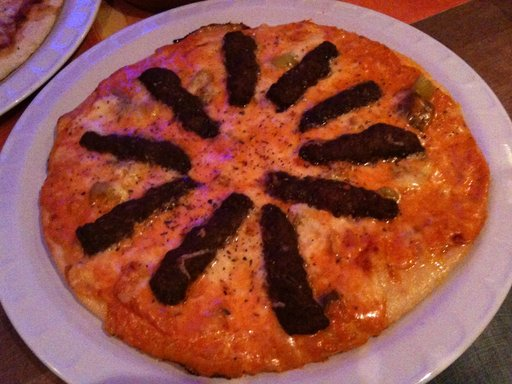

In [62]:
import random
from PIL import Image

#set seed (optional)
random.seed(42)
#get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

#pick a random image path
random_image_path=random.choice(image_path_list)

#get image class from path name
image_class= random_image_path.parent.stem

#open image
img=Image.open(random_image_path)

print(f"random image path {random_image_path}")
print(f"image class : {image_class}")
print(f"image height {img.height} image width {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

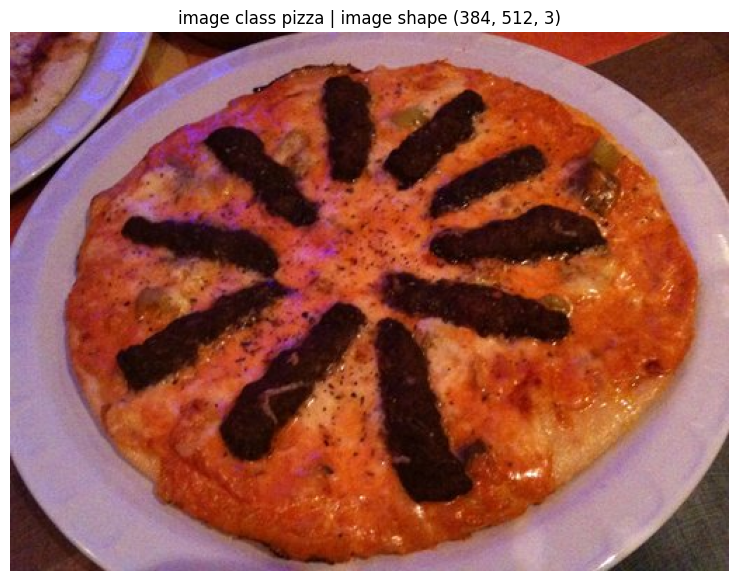

In [63]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"image class {image_class} | image shape {img_as_array.shape}")
plt.axis(False)

## Transforming data
* We convert the images into tensors (a numerical representation of our images)
* Next we turn the tensors into a **torch.utils.data.Dataset** and subsequently into a **torch.utils.data.Dataloader**


In [64]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#transfoming data with torchvision.transforms
data_transform=transforms.Compose([
    #Resize images to 64 x 64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image to tensor
    transforms.ToTensor()
])





In [65]:
data_transform(img)

tensor([[[0.5490, 0.5255, 0.4667,  ..., 0.3020, 0.2824, 0.2863],
         [0.5098, 0.5176, 0.3804,  ..., 0.3373, 0.3020, 0.2863],
         [0.5333, 0.4392, 0.2706,  ..., 0.3333, 0.3059, 0.2706],
         ...,
         [0.2706, 0.2706, 0.2784,  ..., 0.2706, 0.2902, 0.3059],
         [0.2863, 0.2863, 0.2941,  ..., 0.2549, 0.2824, 0.3098],
         [0.2784, 0.2784, 0.2824,  ..., 0.2471, 0.2745, 0.2980]],

        [[0.2980, 0.2549, 0.2039,  ..., 0.1333, 0.1216, 0.1216],
         [0.2902, 0.2863, 0.1373,  ..., 0.1608, 0.1412, 0.1333],
         [0.3137, 0.2157, 0.0627,  ..., 0.1608, 0.1412, 0.1255],
         ...,
         [0.1333, 0.1333, 0.1373,  ..., 0.2314, 0.2471, 0.2588],
         [0.1333, 0.1333, 0.1373,  ..., 0.2275, 0.2471, 0.2667],
         [0.1333, 0.1333, 0.1412,  ..., 0.2353, 0.2471, 0.2627]],

        [[0.3451, 0.3373, 0.2667,  ..., 0.0863, 0.0745, 0.0863],
         [0.3804, 0.4235, 0.2118,  ..., 0.1059, 0.0941, 0.0902],
         [0.3725, 0.3137, 0.1137,  ..., 0.1020, 0.0941, 0.

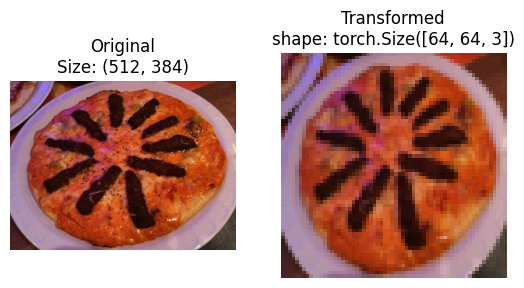

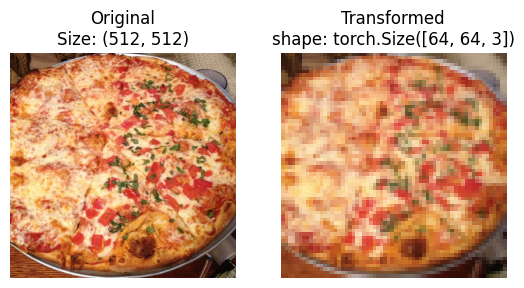

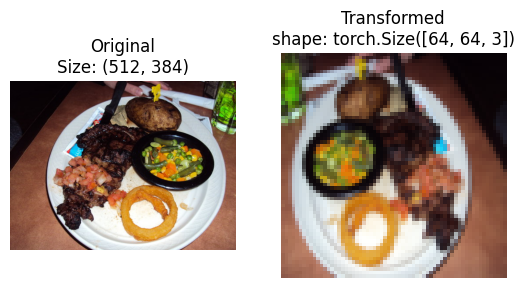

In [66]:
def plot_transformes_images(image_paths, transform, n=3, seed=42):
  #selects random images from a path of images, transforms them and then plots the original vs the transformed versions
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      #tranform the image and plot it
      transformed_image=transform(f).permute(1,2,0) #we use permute to change the shape of the image to have the color channels dim be last
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nshape: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformes_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

## Loading image data using `torchvision.datasets.ImageFolder`
Source : https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [67]:
from torchvision import datasets
train_dir="/data/pizza_steak_sushi/train"
test_dir="/data/pizza_steak_sushi/test"
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, #a transform for the data
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                                transform=data_transform, #a transform for the data
                                )

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [68]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [69]:
#get class names as a dict
class_names_dict=train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [70]:
train_data.samples[0]

('/data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

## Turn loaded images to dataloaders
A `DataLoader` will help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can be able to see that many pages at a time

In [71]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader=DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader=DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e4c76382ef0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e4c76381090>)

In [72]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [73]:
img, label=next(iter(train_dataloader))

print(f"Image shape {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape {label.shape}")

Image shape torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape torch.Size([32])


## Creating a custom `Dataset`

Aside from using `ImageFolder` there is also the option of creating a helper function to replicate its use to load our images.

all custom datasets in pytorch usually subclass - https://pytorch.org/vision/main/datasets.html

## Data Augmentation
Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may have been applying various image tranformations to the training image.

This hopefully leads to a model that is more generalizable to unseen data.

Relative info : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [74]:
#lets look at trivialaugment
from torchvision import transforms

train_transform=transforms.Compose([transforms.Resize(size=(224,224)),
                                   #num_magnitude_bins describes the intensity of the tranformation of the image on a scale 0-31
                                   transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                   transforms.ToTensor()])

test_transform=transforms.Compose([transforms.Resize(size=(224,224)),

                                   transforms.ToTensor()])

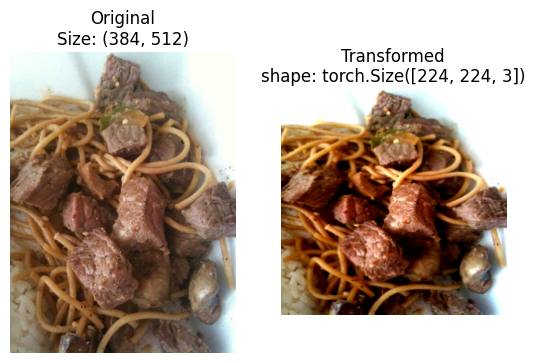

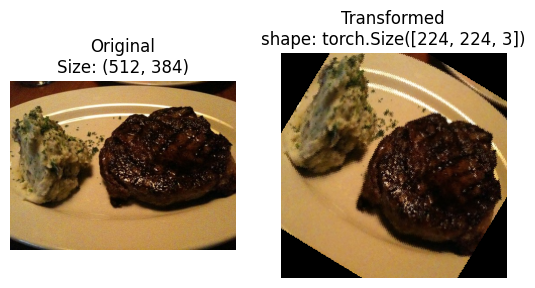

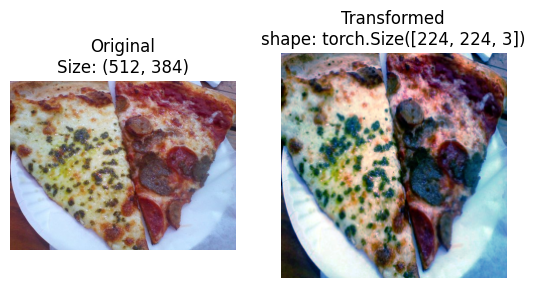

In [75]:
#plot transformed images
plot_transformes_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## Model0 : Tiny VGG without data augmentation

We replicate the simple model structure from the cnn explainer website

https://poloclub.github.io/cnn-explainer/

In [76]:
# transform the data
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [77]:
#Load and transform data
from torchvision import datasets
train_dir="/data/pizza_steak_sushi/train"
test_dir="/data/pizza_steak_sushi/test"
train_data_simple= datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple=datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

#Turn dataset into DataLoaders
import os
from torch.utils.data import DataLoader

#setup batch size and num of works
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

In [78]:
#creating a model class
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value is same as kernel size

    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value is same as kernel size

    )


    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x=self.conv_block_1(x)
    #print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    #x=self.conv_block_3(x)
    #print(x.shape)
    x=self.classifier(x)
    return x



In [79]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=20,
                output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=3, bias=True)
  )
)

In [80]:
#try a forward pass on a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [81]:
#try forward pass
model_0(image_batch.to(device))

tensor([[-0.0221,  0.0261, -0.0208],
        [-0.0237,  0.0247, -0.0191],
        [-0.0230,  0.0218, -0.0194],
        [-0.0217,  0.0203, -0.0156],
        [-0.0224,  0.0257, -0.0185],
        [-0.0215,  0.0209, -0.0157],
        [-0.0225,  0.0255, -0.0211],
        [-0.0210,  0.0243, -0.0171],
        [-0.0231,  0.0245, -0.0202],
        [-0.0192,  0.0218, -0.0106],
        [-0.0226,  0.0246, -0.0183],
        [-0.0237,  0.0240, -0.0178],
        [-0.0218,  0.0256, -0.0222],
        [-0.0242,  0.0253, -0.0181],
        [-0.0231,  0.0220, -0.0170],
        [-0.0245,  0.0233, -0.0171],
        [-0.0228,  0.0255, -0.0149],
        [-0.0220,  0.0241, -0.0178],
        [-0.0250,  0.0234, -0.0147],
        [-0.0224,  0.0237, -0.0177],
        [-0.0226,  0.0213, -0.0167],
        [-0.0214,  0.0218, -0.0165],
        [-0.0254,  0.0214, -0.0194],
        [-0.0203,  0.0238, -0.0146],
        [-0.0238,  0.0246, -0.0164],
        [-0.0198,  0.0247, -0.0176],
        [-0.0197,  0.0257, -0.0172],
 

In [82]:
#install torchinfo package to get information about our model
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─ReLU: 2-4                         [1, 20, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-7                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 20, 26, 26]           3,620
│    └─ReLU: 2-9                         [1, 20, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 20, 13, 13]           --
├─Seq

In [83]:
#create train/test functions
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader:torch.utils.data.DataLoader,
               device=device):
  #set the mode to training
  model.train()

  #set up loss and accuracy values
  train_loss, train_acc= 0,0

  #Loop through the dataloader
  for batch, (X_train, y_train) in enumerate(dataloader):
    #send data to target device
    X_train,y_train=X_train.to(device), y_train.to(device)

    #forward pass
    y_pred=model(X_train)

    #calculate the loss
    loss=loss_fn(y_pred, y_train)
    train_loss+=loss.item()

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backwards
    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate accuracy metric
    y_pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(( y_pred_label==y_train).sum().item()/len(y_pred))

  #get average loss and accuracy per batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc







In [84]:
def test_step(model:torch.nn.Module,
              loss_fn:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              device=device):
  #put model in eval mode
  model.eval()

  #set test loss and accuracy values
  test_loss, test_acc=0,0
  #turn on torch inference mode
  with torch.inference_mode():
    #loop through dataloader
    for batc, (X_test, y_test) in enumerate(dataloader):
      #send data to target device
      X_test, y_test= X_test.to(device), y_test.to(device)

      #do the forward pass
      y_test_pred=model(X_test)

      #calculate loss
      loss=loss_fn(y_test_pred, y_test)
      test_loss+=loss.item()

      #calculate accuracy
      test_pred_labels=y_test_pred.argmax(dim=1)
      test_acc+=(test_pred_labels==y_test).sum().item()/len(test_pred_labels)

    #get metrics for average loss and accuracy
    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
    return test_loss, test_acc

In [85]:
#create a training function

from tqdm.auto import tqdm

def train(model:torch.nn.Module,
         train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device):

  #create empty dictionary to store the results
  results={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  #Loop through the train and test steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=train_step(model=model,
                                     dataloader=train_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     device=device)

    test_loss, test_acc=test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)
    #print out whats happening
    print(f"Epoch : {epoch} | Train loss : {train_loss:.4f} | Train accuracy {train_acc:.4f} | Test loss {test_loss:.4f} | Test accuracy {test_acc:.4f}")

    #update result dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results



In [86]:
#set loss function and optimizer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS=7

#recreate an instance of TinyVGG
model_0= TinyVGG(input_shape=3, #number of color channels on our target images
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)

from timeit import default_timer as timer
start_time=timer()

model_0_results=train(model=model_0, train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)
end_time=timer()
print(f"total training time {end_time-start_time:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.1063 | Train accuracy 0.3047 | Test loss 1.0983 | Test accuracy 0.3011
Epoch : 1 | Train loss : 1.0998 | Train accuracy 0.3281 | Test loss 1.0697 | Test accuracy 0.5417
Epoch : 2 | Train loss : 1.0869 | Train accuracy 0.4883 | Test loss 1.0809 | Test accuracy 0.4924
Epoch : 3 | Train loss : 1.0846 | Train accuracy 0.3984 | Test loss 1.0606 | Test accuracy 0.5729
Epoch : 4 | Train loss : 1.0662 | Train accuracy 0.4219 | Test loss 1.0657 | Test accuracy 0.5644
Epoch : 5 | Train loss : 1.0304 | Train accuracy 0.4375 | Test loss 1.0141 | Test accuracy 0.5426
Epoch : 6 | Train loss : 0.9818 | Train accuracy 0.4180 | Test loss 0.9309 | Test accuracy 0.5938
total training time 8.357 seconds


In [87]:
model_0_results

{'train_loss': [1.106320008635521,
  1.09980046749115,
  1.086875006556511,
  1.0845585465431213,
  1.0661561489105225,
  1.0303702354431152,
  0.9817945286631584],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.3984375,
  0.421875,
  0.4375,
  0.41796875],
 'test_loss': [1.0983202854792278,
  1.0696781078974407,
  1.0808519124984741,
  1.0605724255243938,
  1.0656842390696208,
  1.0141307910283406,
  0.9308868050575256],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394,
  0.5426136363636364,
  0.59375]}

In [88]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [89]:
#make a function to plot our results
def plot_loss_curves(results):
  #get the values from our model result dictionary
  loss=results["train_loss"]
  test_loss=results["test_loss"]
  acc=results["train_acc"]
  test_acc=results["test_acc"]

  #figure how many epochs there were
  epochs=range(len(results["train_loss"]))

  #set up plots
  plt.figure(figsize=(10,7))

  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label="train_accuracy")
  plt.plot(epochs, test_acc, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


## Useful guide on how to interpret different loss curves

Loss curve is one of the most helpful ways to troubleshoot a model

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

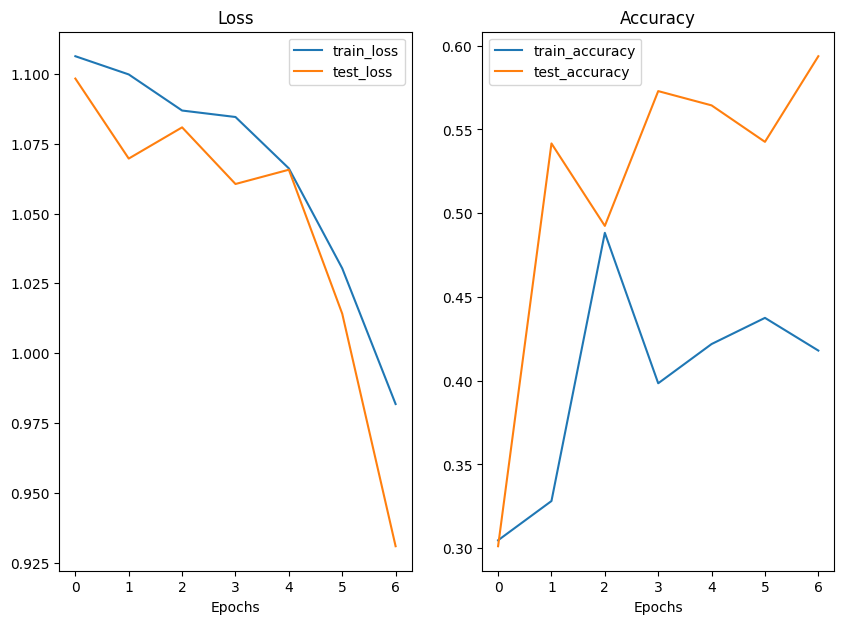

In [90]:
plot_loss_curves(model_0_results)

In [91]:
#create transforms with data augmentation
from torchvision import transforms
train_transform_trivial=transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                            transforms.ToTensor()])

test_transform_trivial=transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()])

In [92]:
#create train and test dataset
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=test_transform_trivial)


In [93]:
#turn our datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

train_dataloader_simple=DataLoader(dataset=test_data_simple,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS)


In [94]:
#we made a new instance of our tinyVGG model but with augmented data as input to observe if any optimization of accuracy and loss is happening
torch.manual_seed(42)
model_1= TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [95]:
#use train() function to train new model

#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set the number of epochs
NUM_EPOCHS=7

#setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)

#start timer
from timeit import default_timer
start_time= timer()

model_1_results =train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)

end_time=timer()
print(f"total training time for model_1 is {end_time-start_time:.3f}")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.1049 | Train accuracy 0.2500 | Test loss 1.1019 | Test accuracy 0.2604
Epoch : 1 | Train loss : 1.0807 | Train accuracy 0.4258 | Test loss 1.1261 | Test accuracy 0.2604
Epoch : 2 | Train loss : 1.0712 | Train accuracy 0.4258 | Test loss 1.1592 | Test accuracy 0.2604
Epoch : 3 | Train loss : 1.1254 | Train accuracy 0.3047 | Test loss 1.1581 | Test accuracy 0.2604
Epoch : 4 | Train loss : 1.0858 | Train accuracy 0.4258 | Test loss 1.1551 | Test accuracy 0.3333
Epoch : 5 | Train loss : 1.0861 | Train accuracy 0.3789 | Test loss 1.1432 | Test accuracy 0.2708
Epoch : 6 | Train loss : 1.0729 | Train accuracy 0.4961 | Test loss 1.1345 | Test accuracy 0.3333
total training time for model_1 is 7.628


In [96]:
model_1_results

{'train_loss': [1.1049137264490128,
  1.0806788504123688,
  1.0712267011404037,
  1.12541463971138,
  1.0858357697725296,
  1.0861191153526306,
  1.072895348072052],
 'train_acc': [0.25,
  0.42578125,
  0.42578125,
  0.3046875,
  0.42578125,
  0.37890625,
  0.49609375],
 'test_loss': [1.1019273201624553,
  1.1260877052942913,
  1.1592440207799275,
  1.1581404606501262,
  1.155133565266927,
  1.1432051062583923,
  1.134477436542511],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333,
  0.2708333333333333,
  0.3333333333333333]}

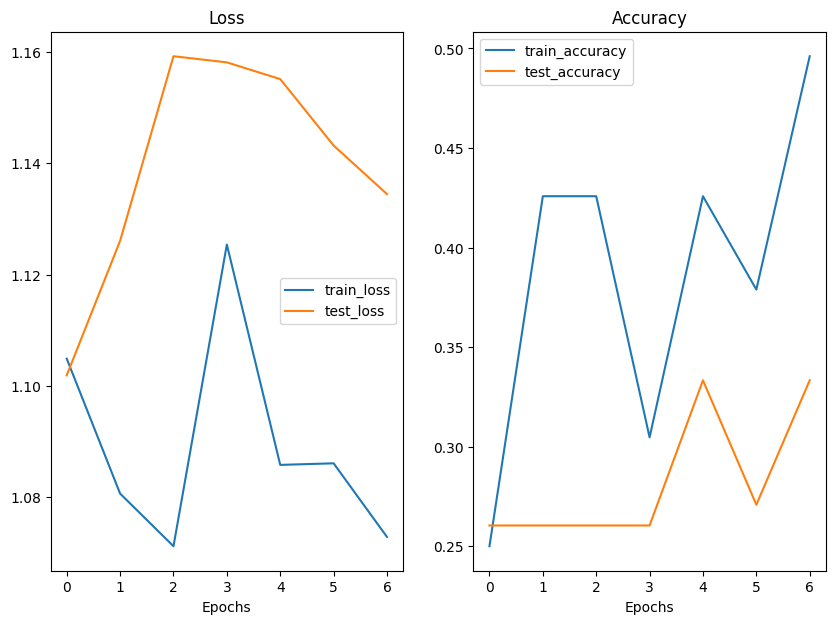

In [97]:
plot_loss_curves(model_1_results)

## Compare Model Results

Afer comparing our modellig experiments on their own, it is important that we also compare them o each other. We do this via :

* Hard coding
* Pytorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
* Weights and Biases
* MLFlow - https://mlflow.org/

In [98]:
#plot the loss curves of boh models on hte same diagram
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104914,0.250000,1.101927,0.260417
1,1.080679,0.425781,1.126088,0.260417
2,1.071227,0.425781,1.159244,0.260417
3,1.125415,0.304688,1.158140,0.260417
4,1.085836,0.425781,1.155134,0.333333
5,1.086119,0.378906,1.143205,0.270833
6,1.072895,0.496094,1.134477,0.333333


range(0, 7)


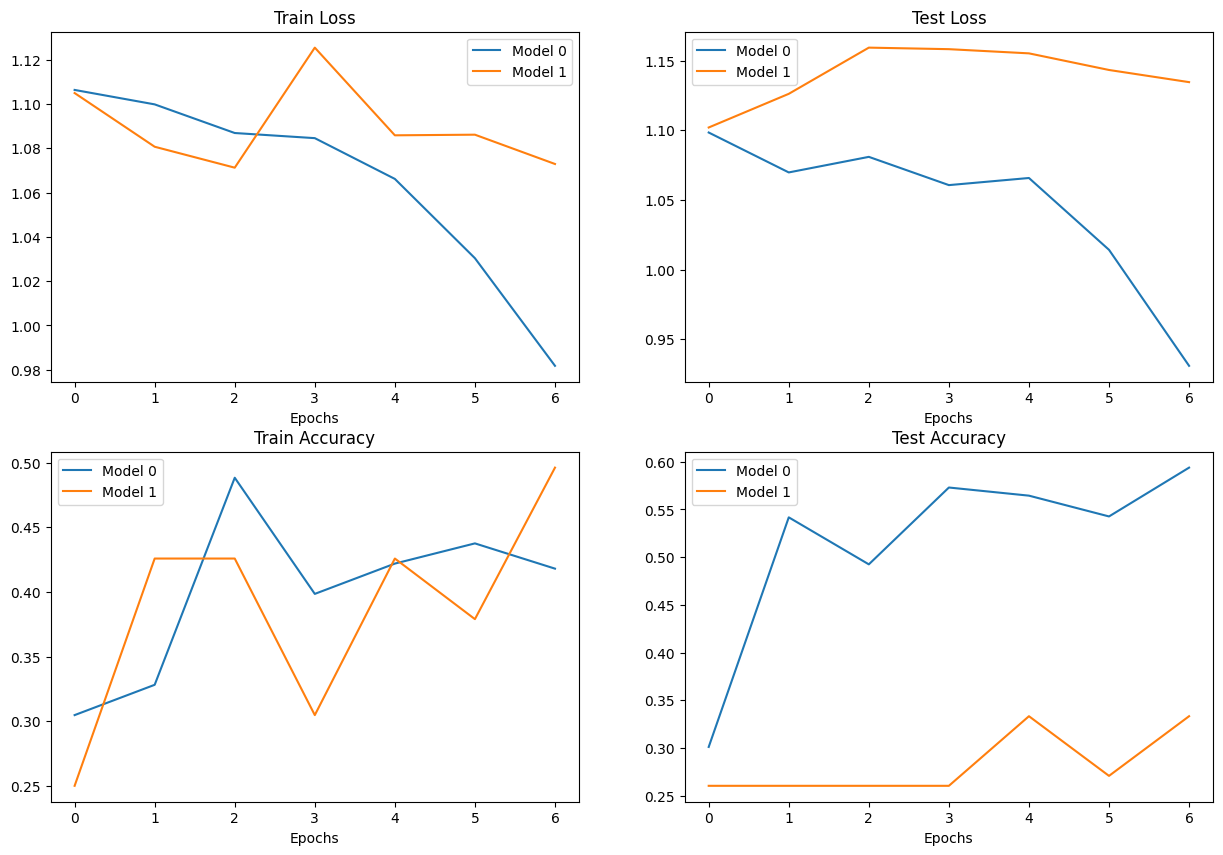

In [99]:
#setup a plot
plt.figure(figsize=(15,10))

#get the number of epochs
epochs=range(len(model_0_df))
print(epochs)

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

#plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

#plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

#plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()


## Making a prediction on a custom image

The question we will be focused on answering is how do we make a prediciton on an image/sample that is neother on the train or test dataset

In [103]:
#Download custom image
import requests

#setup custom image path
custom_image_path =data_path / "04-pizza-dad.jpeg"
print(custom_image_path)

#Download the image if it does not already exists
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

/data/04-pizza-dad.jpeg


In [104]:
custom_image_path

PosixPath('/data/04-pizza-dad.jpeg')

In [106]:
#read a custom image
import torchvision
custom_image_unit8=torchvision.io.read_image(str(custom_image_path))
print(f"custom image tensor:\n {custom_image_unit8}")
print(f"custom image shape: {custom_image_unit8.shape}")
print(f"custom image datatype : {custom_image_unit8.dtype}")

custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
custom image shape: torch.Size([3, 4032, 3024])
custom image data

(-0.5, 3023.5, 4031.5, -0.5)

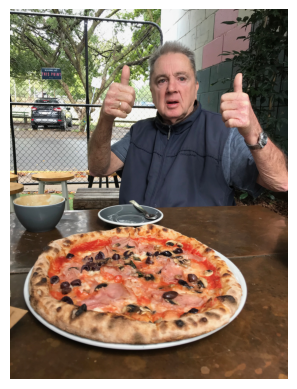

In [109]:
plt.imshow(custom_image_unit8.permute(1,2,0))
plt.axis(False)

Before we pass the image to our model we have to make sure its shape and datatype can be processed by our model. To do that, there are a few things we need to change

* Make tensor form datatype from unit8 to float32
* Convert image shape to 64x64x3
* Make sure it's on the right device

In [113]:
#convert the image to float32 type
#we divide by 255 to change the scale and make it similar o the scaling in our train/test dataset
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

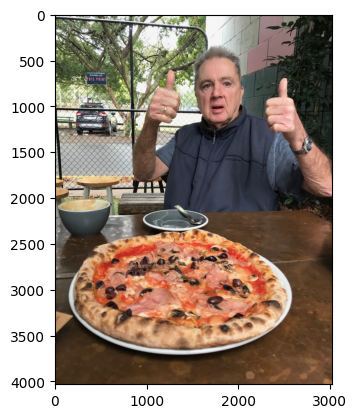

In [115]:
plt.imshow(custom_image.permute(1,2,0))


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


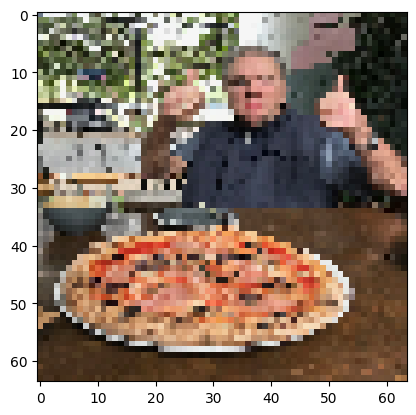

In [117]:
#change image shape
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])

#transform target image
custom_image_transformed=custom_image_transform(custom_image)

#plot transformed image
plt.imshow(custom_image_transformed.permute(1,2,0))


In [119]:
#make the prediction
#this will error because a batch size needs to be added
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [120]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [122]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0662,  0.0240, -0.2115]], device='cuda:0')

In [123]:
#convert logits to probs
custom_image_pred_probs=torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3682, 0.3530, 0.2789]], device='cuda:0')

In [125]:
#convert to predction labels
custom_image_pred_label=torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label, class_names[custom_image_pred_label]

(tensor([0], device='cuda:0'), 'pizza')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


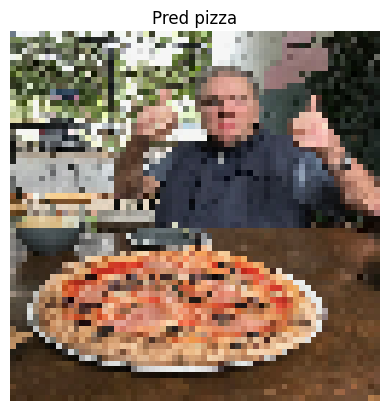

In [127]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names=None,
                        transform=None,
                        device=device):
  #load he image
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

  #divide the pixel values by 255 to get them in range [0,1]
  target_image=target_image/255

  #transform if necessary
  if transform:
    target_image=transform(target_image)

  #make sure the model is on the target device
  model.to(device)

  #turn on inference mode and make prediciton
  model.eval()
  with torch.inference_mode():
    #add an extra dimension to the image (batch dim)
    target_image=target_image.unsqueeze(0)

    target_image_pred=model(target_image.to(device))


  #convert logits to label
  target_image_label=torch.softmax(target_image_pred, dim=1).argmax(dim=1)

  #plot image alongside prediction
  plt.imshow(target_image.squeeze().permute(1,2,0)) #remove batch dim and rearrange shape to [height, width, color channel]
  if class_names:
    title=f"Pred {class_names[target_image_label.cpu()]}"
  else:
    title=f"Pred {target_image_label}"

  plt.title(title)
  plt.axis(False)


pred_and_plot_image(model=model_1,image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
